# 02 - Randomized Experiments and Stats Review
 
 
## Brute Force Independence with Randomization
* 관측된 결과 Y는 처치 여부에 따라 달라진다. 이는 잠재적 결과가 처치와 독립적이라는 것과는 다른 의미를 가진다. 
* 무작위로 처치를 배정하게 되면 두 그룹간의 유일한 차이는 처치밖에 없기 떄문에 두 그룹의 결과 차이는 처치에 따른 것으로 볼 수 있다. 기본적으론 랜덤화는 처치와 잠재적 결과를 독립적으로 만든다.

## An A/B Testing Example
* 저가형 상품을 구독하는 사용자들에게 프리미엄 서비스를 판매하기 위해 교차 판매 이메일을 저가형 사품 구독자들에게 보낸 사례
* 이 예시에서 마케팅팀은 애초에 전환 가능성이 높다고 생가갛ㄴ 고객에게만 이메일을 보낸 사실을 알게 되었고 이는 아래의 수식과 같이 표현될 수 있다.
    * $E[Conversion_0 | Email = 1] > E[Conversion_0 | Email = 0]$
* 이 때 무작위로 이메일을 고객에게 보내면 비교 가능한 상황을 만들 수 있다.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 5)


In [9]:
import numpy as np # for numerical computation
import matplotlib.pyplot as plt

data = pd.read_csv("./data/cross_sell_email.csv")
data

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
...,...,...,...,...
321,1,no_email,16,0
322,1,long,24,1


In [3]:
(data
 .groupby(["cross_sell_email"])
 .mean())

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


* 두 그룹이 비슷한지 평가하는 방법은 여러가지 인데 간단하게 실험 대상 집단 사이의 정규화 차이를 아래와 같이 계산해 평가할 수 있다.
    * $\frac{\hat{\mu_tr} - \hat{\mu_co}}{\sqrt{(\hat{\sigma_tr^2}+\hat{\sigma_co^2})}/2}$

In [4]:
X = ["gender", "age"]

mu = data.groupby("cross_sell_email")[X].mean()
var = data.groupby("cross_sell_email")[X].var()

norm_diff = ((mu - mu.loc["no_email"])/
             np.sqrt((var + var.loc["no_email"])/2))

norm_diff

,gender,age
cross_sell_email,,
long,0.015802,0.221423
no_email,0.000000,0.000000
short,0.184341,0.087370


* 위 차이가 너무 작거나 너무 크면 좋지 않은데, 경험적으로 0.5 정도 값을 임계값으로 설정할 수 있다. 위 사례에서는 짧은 이메일을 받은 그룹은 성별 차이가 크고, 긴 이메일을 받은 그룹은 나이차이가 큰 것을 알 수 있다.

## The Ideal Experiment
* RCT(무작위 통제 실험)는 인과효과를 파악하는 가장 신뢰할 수 있고 간단한 방법이다. 현실적으로 RCT를 적용할 수 없는 이유는 시간과 비용 문제로 생기게 되는데 때문에 RCT를 일종의 벤치마크로 활용하는 것을 목표로 삼아야 한다.

 
## The Most Dangerous Equation
* 드무아브르 공식
    * $SE = \frac{\sigma}{\sqrt{n}}$
* 표준오차는 표본크기에 루트를 씌운 값으로 표준편차를 나눈 값이다. 
* 아래 예시는 브라진 학교에서의 학교별 성적 데이터인데, 단순히 학교별 학생 수와 성적의 관계를 본다면 규모가 작은 학교일수록 학업 성취도가 높다는 결론을 낼수 있다.
* 여기서 문제는 학생 수가 적은 학교들의 성적은 불확실성이 크가는 것이다.
* 불확실성을 정량화 하는 방법은 추정값의 분산을 계산하는 것이다.
    * 예시에서 우수한 성적을 내는 학생이 많은 학교일수록 더 좋은 학교라고 크게 확신할 수 있지만 전교생이 10명인 학교에서 8명의 학생이 우수한 성적을 보인다면 좀 더 의심해봐야 할 것이다.

In [10]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from cycler import cycler
import matplotlib

default_cycler = (cycler(color=['0.1', '0.5', '1.0']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

matplotlib.rcParams.update({'font.size': 18})

In [11]:
df = pd.read_csv("data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
...,...,...,...,...
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


Text(0.5, 1.0, 'Number of Students of 1% Top Schools (Right)')

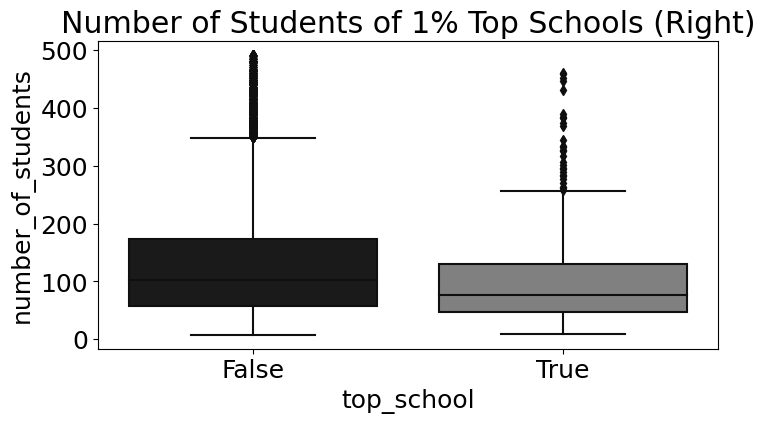

In [12]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(8,4))
ax = sns.boxplot(x="top_school", y="number_of_students", data=plot_data)

plt.title("Number of Students of 1% Top Schools (Right)")


Text(0.5, 1.0, 'ENEM Score by Number of Students in the School')

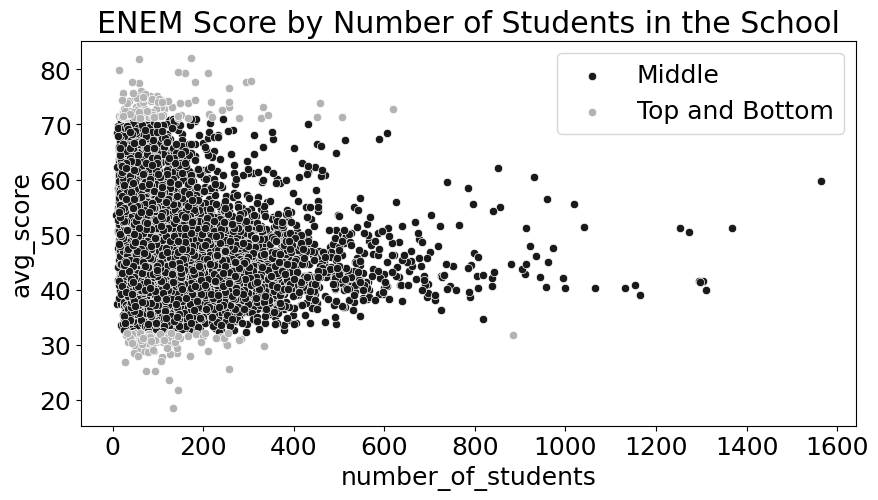

In [13]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([(d["avg_score"] > q_99) | (d["avg_score"] < q_01)],
                                                 ["Top and Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", data=plot_data.query("Group=='Middle'"), label="Middle")
ax = sns.scatterplot(y="avg_score", x="number_of_students", data=plot_data.query("Group!='Middle'"), color="0.7", label="Top and Bottom")

plt.title("ENEM Score by Number of Students in the School")



##  The Standard Error of Our Estimates
* 이메일 프로모션 예시에서 짧은 이메일이 긴 이메일 보다 효과가 좋은 것으로 나타났는데 이 효과가 우연이 아니라고 확신할만큼 표본 크기가 충분한지, 이 효과가 통계적으로 유의한지를 확인해볼 필요가 있다.

In [14]:
data = pd.read_csv("./data/cross_sell_email.csv")

short_email = data.query("cross_sell_email=='short'")["conversion"]
long_email = data.query("cross_sell_email=='long'")["conversion"]
email = data.query("cross_sell_email!='no_email'")["conversion"]
no_email = data.query("cross_sell_email=='no_email'")["conversion"]

data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64

In [15]:
def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Long Email:", se(long_email))
print("SE for Short Email:", se(short_email))

SE for Long Email: 0.021946024609185506
SE for Short Email: 0.030316953129541618


In [16]:
print("SE for Long Email:", long_email.sem())
print("SE for Short Email:", short_email.sem())

SE for Long Email: 0.021946024609185506
SE for Short Email: 0.030316953129541618


## Confidence Intervals
* 만약 고객이 짧은 이메일을 받을 때마다 전환될 확률은 8%이고 실험을 10000번 정도 실행했다 가정해보자. 실험마다 100명의 고객 표본을 수집해 짧은 이메일을 보내 전환율의 평균값 10000개를 얻는다면 실제 평균인 0.08 중심으로 분포할 것이다.

In [17]:
n = 100
conv_rate = 0.08

def run_experiment(): 
    return np.random.binomial(1, conv_rate, size=n)

np.random.seed(42)

experiments = [run_experiment().mean() for _ in range(10000)]

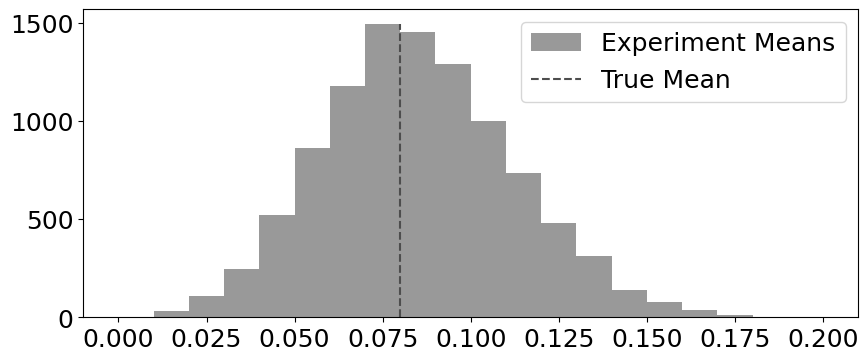

In [18]:
plt.figure(figsize=(10,4))
freq, bins, img = plt.hist(experiments, bins=20, label="Experiment Means", color="0.6")
plt.vlines(conv_rate, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="0.3")
plt.legend()


* 실험의 평균값은 실제 이상적인 평균과 항상 일치할 수 없지만 표준오차를 사용해 진행한 실험의 95%에서 실제 평균을 포함하는 구간을 만들 수 있다. (95% 신뢰구간)
* 성공률이 8%인 베르누이 분포를 시각화하면 아래의 그림과 같다. 여기서 데이터 분포가 정규분포가 아니더라도 데이터의 평균의 분포는 일정한 표본 수를 넘게 되면 항상 정규분포를 따른다 (중심극한정리)
* 이를 이용해 신뢰구간을 계산할 때 정규분포의 질량의 9%가 평균 위아래로 표준편차 1.96배 내에 있다는 통계적 지식을 활용할 수 있다. 

(array([92.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

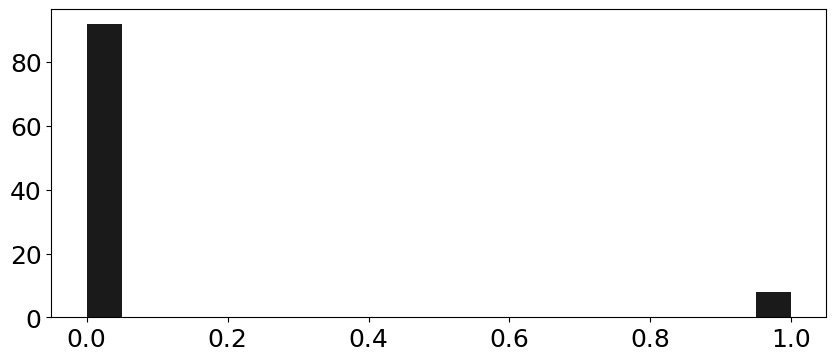

In [20]:
np.random.seed(42)
plt.figure(figsize=(10,4))
plt.hist(np.random.binomial(1, 0.08, 100), bins=20)


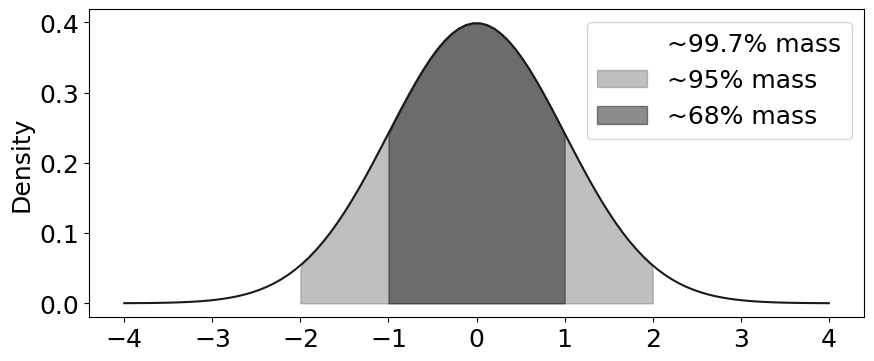

In [21]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(10,4))
plt.plot(x, y, linestyle="solid")
plt.fill_between(x.clip(-3, +3), 0, y, alpha=0.5, label="~99.7% mass", color="C2")
plt.fill_between(x.clip(-2, +2), 0, y, alpha=0.5, label="~95% mass", color="C1")
plt.fill_between(x.clip(-1, +1), 0, y, alpha=0.5, label="~68% mass", color="C0")
plt.ylabel("Density")
plt.legend()


In [22]:
exp_se = short_email.sem()
exp_mu = short_email.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print("95% CI for Short Email: ", ci)

95% CI for Short Email:  (0.06436609374091676, 0.18563390625908324)


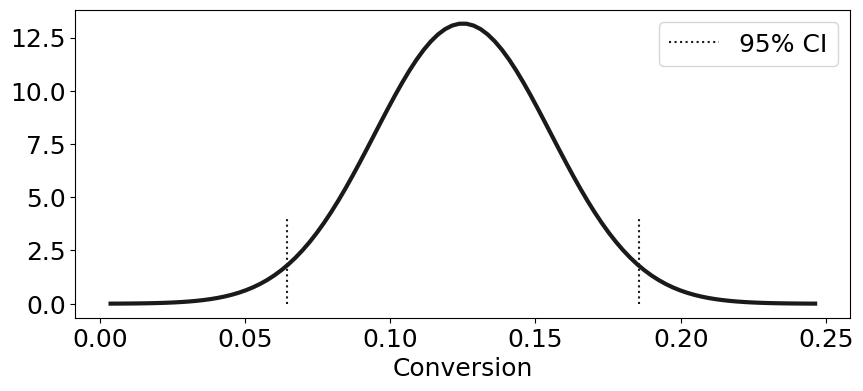

In [23]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.xlabel("Conversion")
plt.legend()


In [24]:
from scipy import stats

z = np.abs(stats.norm.ppf((1-.99)/2))
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(0.04690870373460816, 0.20309129626539185)

In [25]:
stats.norm.ppf((1-.99)/2)

-2.5758293035489004

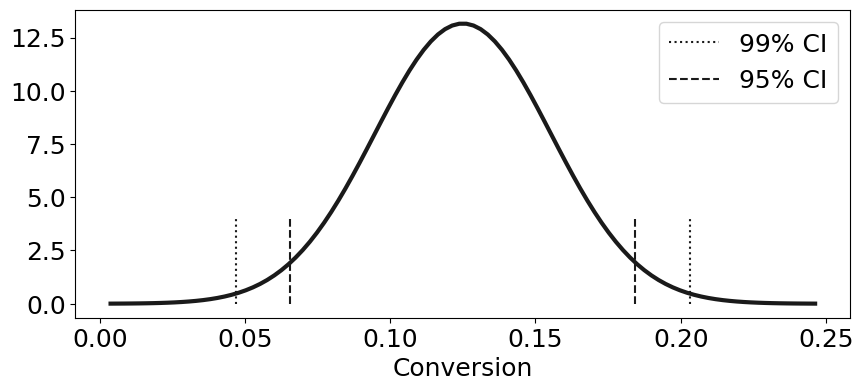

In [26]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="99% CI")


ci_95 = (exp_mu - 1.96 * exp_se, exp_mu + 1.96 * exp_se)

plt.vlines(ci_95[1], ymin=0, ymax=4, ls="dashed")
plt.vlines(ci_95[0], ymin=0, ymax=4, ls="dashed", label="95% CI")
plt.xlabel("Conversion")
plt.legend()

In [27]:
def ci(y: pd.Series):
    return (y.mean() - 2 * y.sem(), y.mean() + 2 * y.sem())

print("95% CI for Short Email:", ci(short_email))
print("95% CI for Long Email:", ci(long_email))
print("95% CI for No Email:", ci(no_email))

95% CI for Short Email: (0.06436609374091676, 0.18563390625908324)
95% CI for Long Email: (0.01115382234126202, 0.09893792077800403)
95% CI for No Email: (0.0006919679286838468, 0.08441441505003955)


* 짧은 이메일 외에도 다른 케이스에 대해 동일하게 신뢰구간을 구하면 아래와 ㄱ타다.
* 여기서 세 그룹의 95% 신뢰구간이 겹치는데 이 구간이 겹치지 않았다면 그룹 간의 전환율 차이가 우연이 아닐 가능성이 높다고 할 수 있다.
* 결론을 내리기 위해 이러한 차이가 통계적으로 유의한지 검정할 필요가 있다. 

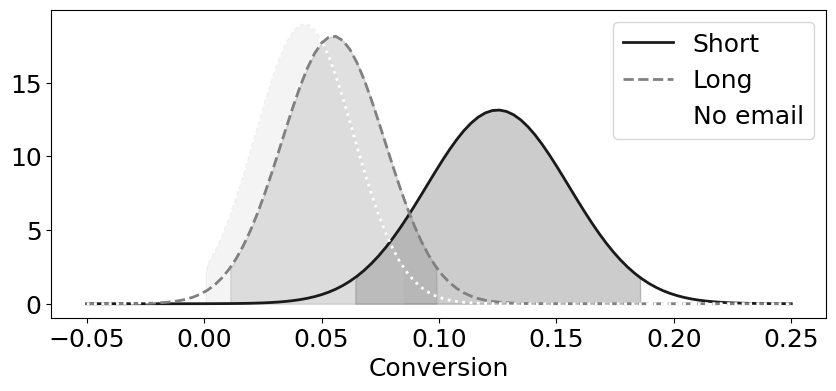

In [28]:
plt.figure(figsize=(10,4))

x = np.linspace(-0.05, .25, 100)
short_dist = stats.norm.pdf(x, short_email.mean(), short_email.sem())
plt.plot(x, short_dist, lw=2, label="Short", linestyle=linestyle[0])
plt.fill_between(x.clip(ci(short_email)[0], ci(short_email)[1]), 0, short_dist, alpha=0.2, color="0.0")

long_dist = stats.norm.pdf(x, long_email.mean(), long_email.sem())
plt.plot(x, long_dist, lw=2, label="Long", linestyle=linestyle[1])
plt.fill_between(x.clip(ci(long_email)[0], ci(long_email)[1]), 0, long_dist, alpha=0.2, color="0.4")

no_email_dist = stats.norm.pdf(x, no_email.mean(), no_email.sem())
plt.plot(x, no_email_dist, lw=2, label="No email", linestyle=linestyle[2])
plt.fill_between(x.clip(ci(no_email)[0], ci(no_email)[1]), 0, no_email_dist, alpha=0.2, color="0.8")

plt.xlabel("Conversion")
plt.legend()


## Hypothesis Testing
* 불확실성을 반영하는 또 다른 방법은 가설 검정을 통해 결과를 제시하는 것이다.
* 주로 두 그룹 (혹은 그 이상)의 평균 차이가 0(혹은 특정 값)과 통계적으로 유의한 차이가 있는지에 대한 질문을 다룬다.

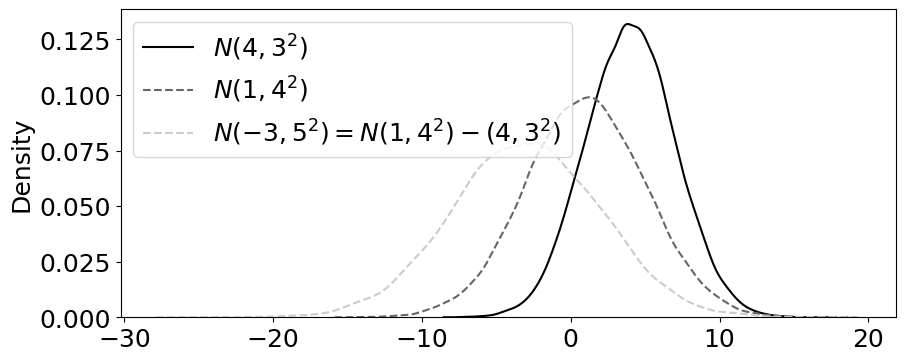

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt

np.random.seed(123)

n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1

plt.figure(figsize=(10,4))
sns.distplot(n1, hist=False, label="$N(4,3^2)$", color="0.0", kde_kws={"linestyle":linestyle[0]})
sns.distplot(n2, hist=False, label="$N(1,4^2)$", color="0.4", kde_kws={"linestyle":linestyle[1]})
sns.distplot(n_diff, hist=False,
             label=f"$N(-3, 5^2) = N(1,4^2) - (4,3^2)$", color="0.8", kde_kws={"linestyle":linestyle[1]})
plt.legend();

In [30]:
diff_mu = short_email.mean() - no_email.mean()
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(f"95% CI for the differece (short email - no email):\n{ci}")

95% CI for the differece (short email - no email):
(0.01023980847439844, 0.15465380854687816)


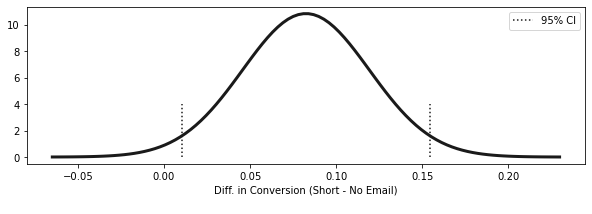

In [25]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)

plt.figure(figsize=(10,3))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.xlabel("Diff. in Conversion (Short - No Email)\n")
plt.legend()
plt.subplots_adjust(bottom=0.15)





### Null Hypothesis
* 위 예시에서 귀무가설은 아래와 같다.
    * $H_0 : Conversion_{no_email} = Conversion_{short_email}$
* 95% 신뢰구간 내에 0이 포함되지 않기 때문에 귀무가설이 참이라면 이러한 결과를 관측할 확률은 매우 낮다고 할 수 있다. (유의수준 $\alpha=0.05$ 하에 귀무가설 기각)
* 유의수준은 귀무가설이 참인데도 이를 기각하는 1종 오류를 범할 확률을 나타낸다.
* (참고)

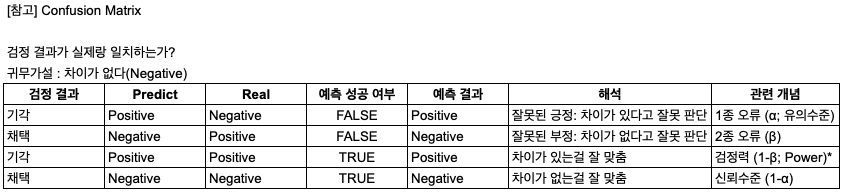

In [32]:
# shifting the CI
diff_mu_shifted =  short_email.mean() - no_email.mean() - 0.01 
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2)

ci = (diff_mu_shifted - 1.96*diff_se, diff_mu_shifted + 1.96*diff_se)
print(f"95% CI 1% difference between (short email - no email):\n{ci}")

95% CI 1% difference between (short email - no email):
(0.00023980847439844521, 0.14465380854687815)



### Test Statistic
* 신뢰구간 외에도 검정통계량을 사용해 귀무가설을 기각하는 것이 유용할 수 있다. 가장 널리 사용되는 검정통계량 중 하나는 t 통계량이다. 

In [33]:
t_stat = (diff_mu - 0) / diff_se
t_stat

2.2379512318715364

## P-values
* P-value 는 귀무가설이 참이라는 가정 하에 관측된 결과보다 더 극단적인 결과가 실제로 관측될 확률을 의미한다.
    * 귀무가설이 참이라는 가정 하에 얻어진 통계량이 귀무가설을 얼마나 지지하는지를 나타내는 확률

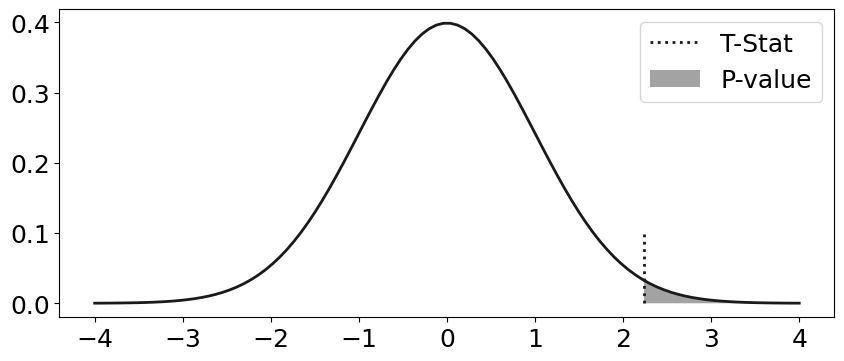

In [34]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=2)
plt.vlines(t_stat, ymin=0, ymax=0.1, ls="dotted", label="T-Stat", lw=2)
plt.fill_between(x.clip(t_stat), 0, y, alpha=0.4, label="P-value")
plt.legend()

In [35]:
print("P-value:", (1 - stats.norm.cdf(t_stat))*2)

P-value: 0.025224235562152142


## Power
* 검정력은 귀무가설이 거짓일 때 이 귀무가설을 올바르게 기각할 확률을 의미한다. 
* $\beta$는 귀무가설이 실제로 거짓일 때 이를 기각하지 않을 확률을 의미한다.
* 일반적으로 요구되는 산업표준: 유의수준(α) 5%, 검정력(1-β) 80% 

In [36]:
stats.norm.cdf(0.84)

0.7995458067395503

## Sample Size Calculation
* 귀무가설이 거짓일 떄 귀무가설과 관측된 추정값의 차이인 $\delta$값을 감지할 수 있어야 한다.
* 이메일 예시에서 본 것처럼 8%의 차이를 감지하고자 한다면 적어도 8% = 2.8SE 를 감지할 표본크기를 확보해야 한다.
* 80%의 검정력과 95%의 신뢰도를 원할 때 표본 크기 공식은 아래와 같다.
    * $\delta = 2.8\sigma\sqrt{2/n}$
    * $n = 2*2.8^2\sigma^2 / \delta^2 \approx 16\sigma^2 / \delta^2$
* 정리하면
    * 검출해내고 싶은 효과($\delta$)가 얼마인지에 따라 필요한 표본 크기는 달라진다.
    * 과거 데이터에 기반한 관심 지표의 표준편차($\sigma$)에 따라 필요한 표본 크기는 달라진다.
(예시)

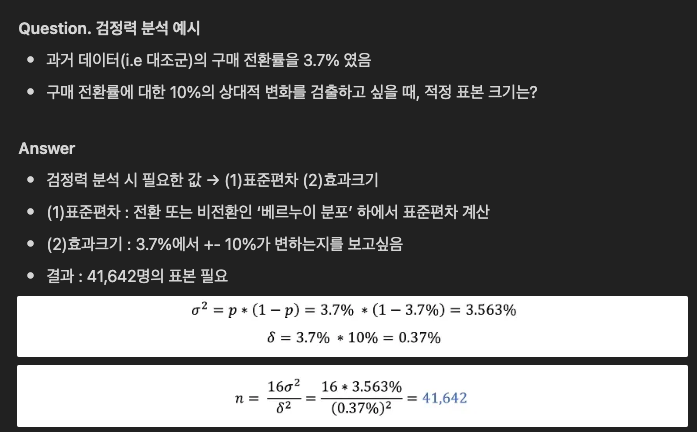

In [37]:
# in the book it is np.ceil(16 * no_email.std()**2/0.01), but it is missing the **2 in the denominator.
np.ceil(16 * (no_email.std()/0.08)**2)

103.0

In [38]:
data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64